In [1]:
import pandas as pd
from utils import *

/Users/Xiongjing/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Load preprocessed data
dataPreprocessed = pd.read_pickle("preprocessedtext.pkl")
dataPreprocessed

,index,sentiment,text,target,processedText
0,670935,0,"@TheRealScarab PA system bugs are a bummer, so...",0,personal assistant system bugs summer sorry
1,649589,0,oh daaamnnn! the firemen ball's on the 14th an...,0,overhead damn firemen ball 14th I cannes signi...
2,2028,0,"I don't want to be cold in April, but I am",0,I want time cold april I ante meridian amplitu...
3,669856,0,@JaredOngie haha its too cold down here bt ot...,0,haha I think think cold instant message fine s...
4,458897,0,Upset I can't find my CHI!,0,upset I find miss chi
...,...,...,...,...,...
139995,860453,4,@lynnnein Lmao I think I'll always have growin...,1,laugh ass I think I grow pains grow
139996,1070764,4,"@marinavorobyev no doubt, we have to support e...",1,doubt time support
139997,978520,4,"now on, gonna have a word of the day todays w...",1,word day todays word hmm apocalypse
139998,1502159,4,@LolaHedoOnline awful and sweaty are two of my...,1,awful sweat miss favorite things lime face


# Split And Tokenize Data

In [20]:
from sklearn.model_selection import train_test_split
# Split data into train, validation, and test sets
df_train, df_test_val, y_train, y_test_val = train_test_split(dataPreprocessed['processedText'], dataPreprocessed.target, test_size=0.3, random_state=0)
df_test, df_val, y_test, y_val = train_test_split(df_test_val, y_test_val, test_size=0.5, random_state=0)

# Tokenize text
textToken = [_text.split() for _text in dataPreprocessed['processedText']]



In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizing and padding the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataPreprocessed['processedText'])
vocab_size = len(tokenizer.word_index) + 1
input_length = 150
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train), maxlen=input_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test), maxlen=input_length)

2023-11-18 20:28:13.048739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
from keras.layers import Embedding
embedding_dimensions = 300

def createEmbeddingMatrix(model, modelName):
  embedding_matrix = np.zeros((vocab_size, embedding_dimensions))
  for word, i in tokenizer.word_index.items():
    if modelName == 'Glove':
      embedding_value = embedding_vector.get(word)
      if embedding_value is not None:
          embedding_matrix[i] = embedding_value
    else:
      if word in model.wv:
        embedding_matrix[i] = model.wv[word]
  print("Embedded matrix shape for ", modelName ,":", embedding_matrix.shape)
  return embedding_matrix

In [22]:
embedding_vector = {}
f = open('glove.6B.300d.txt')
for line in f:
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

# Advance models

## Creating embedding models

In [14]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(vector_size=embedding_dimensions, window=6, min_count=3, workers=8, epochs=20)
w2v_model.build_vocab(textToken)

In [6]:
from gensim.models import FastText

fasttext_model = FastText(vector_size=embedding_dimensions, window=6, min_count=3, workers=8, epochs=20)
fasttext_model.build_vocab(textToken)

In [24]:
# Embedding layers
embedding_layer_word2vec = Embedding(vocab_size, embedding_dimensions, weights=[createEmbeddingMatrix(w2v_model, "Word2vec")], input_length=input_length, trainable=False)
embedding_layer_fasttext = Embedding(vocab_size, embedding_dimensions, weights=[createEmbeddingMatrix(fasttext_model, "FastText")], input_length=input_length, trainable=False)
embedding_layer_glove = Embedding(vocab_size, embedding_dimensions, weights=[createEmbeddingMatrix(embedding_vector, 'Glove')], input_length=input_length, trainable=False)

Embedded matrix shape for  Word2vec : (48850, 300)
Embedded matrix shape for  FastText : (48850, 300)
Embedded matrix shape for  Glove : (48850, 300)


In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Callbacks
callbacks = [ReduceLROnPlateau(factor=0.1, min_lr=0.001, monitor='val_loss', verbose=1),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# LSTM model definition
def simple_lstm(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
# Training and evaluating models
def train_and_evaluate(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train, y_train, batch_size=512, epochs=10, verbose=1, validation_split=0.1, callbacks=callbacks)
    evaluation_score = model.evaluate(x_test, y_test, verbose=0)
    return history, evaluation_score

## Word2Vec

In [29]:
# Train and evaluate with Word2Vec
model_word2vec = simple_lstm(embedding_layer_word2vec)
history_word2vec, score_word2vec = train_and_evaluate(model_word2vec, x_train, y_train, x_test, y_test)


Epoch 1/10
173/173 [==============================] - 389s 2s/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 2/10
173/173 [==============================] - 374s 2s/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.4993 - lr: 0.0010
Epoch 3/10
173/173 [==============================] - 380s 2s/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6931 - val_accuracy: 0.5041 - lr: 0.0010
Epoch 4/10
173/173 [==============================] - 353s 2s/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 5/10
173/173 [==============================] - 348s 2s/step - loss: 0.6931 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 6/10
173/173 [==============================] - 348s 2s/step - loss: 0.6930 - accuracy: 0.5005 - val_loss: 0.6929 - val_accuracy: 0.5061 - lr: 0.0010
Epoch 7/10
173/173 [==============================] - 345s 2s/st

## FastText

In [39]:
# Train and evaluate with FastText
model_fasttext = simple_lstm(embedding_layer_fasttext)
history_fasttext, score_fasttext = train_and_evaluate(model_fasttext, x_train, y_train, x_test, y_test)


Epoch 1/10
173/173 [==============================] - 221s 1s/step - loss: 0.6931 - accuracy: 0.5040 - val_loss: 0.6931 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 2/10
173/173 [==============================] - 237s 1s/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
173/173 [==============================] - 212s 1s/step - loss: 0.6931 - accuracy: 0.5014 - val_loss: 0.6929 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 4/10
173/173 [==============================] - 202s 1s/step - loss: 0.6974 - accuracy: 0.5007 - val_loss: 0.6929 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 5/10
173/173 [==============================] - 203s 1s/step - loss: 0.7192 - accuracy: 0.5019 - val_loss: 0.6929 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 6/10
173/173 [==============================] - 206s 1s/step - loss: 0.6928 - accuracy: 0.5006 - val_loss: 0.6927 - val_accuracy: 0.5005 - lr: 0.0010


## Glove

In [43]:
# Train and evaluate with Glove
model_glove = simple_lstm(embedding_layer_glove)
history_glove, score_glove = train_and_evaluate(model_glove, x_train, y_train, x_test, y_test)


Epoch 1/10
173/173 [==============================] - 220s 1s/step - loss: 0.6898 - accuracy: 0.5081 - val_loss: 0.6884 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 2/10
173/173 [==============================] - 213s 1s/step - loss: 0.6883 - accuracy: 0.5090 - val_loss: 0.6882 - val_accuracy: 0.5065 - lr: 0.0010
Epoch 3/10
173/173 [==============================] - 233s 1s/step - loss: 0.6877 - accuracy: 0.5092 - val_loss: 0.6879 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 4/10
173/173 [==============================] - 206s 1s/step - loss: 0.6873 - accuracy: 0.5065 - val_loss: 0.6881 - val_accuracy: 0.5120 - lr: 0.0010
Epoch 5/10
173/173 [==============================] - 206s 1s/step - loss: 0.6868 - accuracy: 0.5088 - val_loss: 0.6880 - val_accuracy: 0.5121 - lr: 0.0010
Epoch 6/10
173/173 [==============================] - 207s 1s/step - loss: 0.6863 - accuracy: 0.5108 - val_loss: 0.6881 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 7/10
173/173 [==============================] - 204s 1s/st

In [30]:
# Visualization function
def plot_accuracy_loss(history, title):
    plt.suptitle(title)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

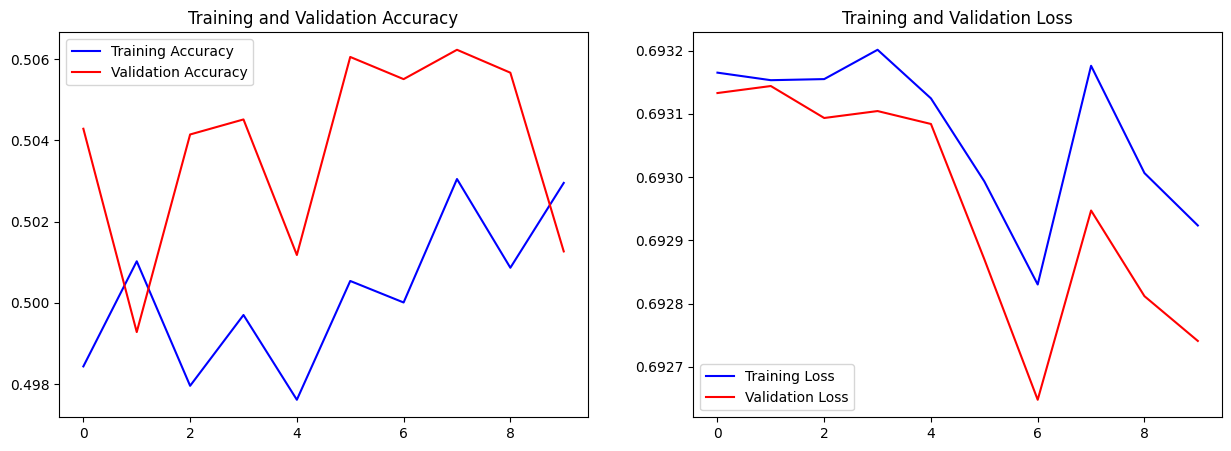

In [31]:
# Plotting results
plot_accuracy_loss(history_word2vec, 'Word2Vec Model')


In [38]:
print(f'Accuracy: {score_word2vec[1]}')

Accuracy: 0.5067573189735413


<Figure size 640x480 with 0 Axes>

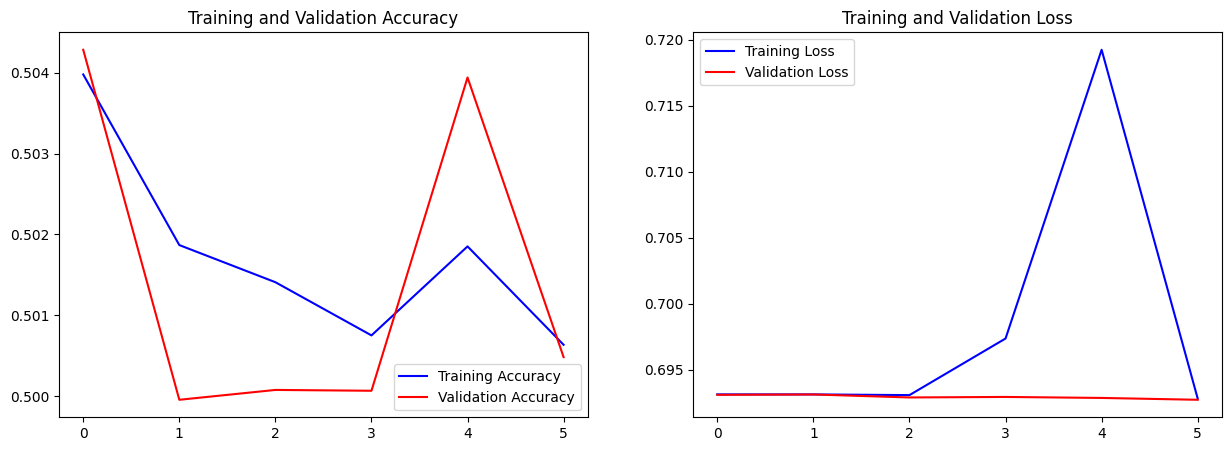

In [40]:
plot_accuracy_loss(history_fasttext, 'FastText Model')

In [41]:
print(f'Accuracy: {score_fasttext[1]}')

Accuracy: 0.5060771703720093


<Figure size 640x480 with 0 Axes>

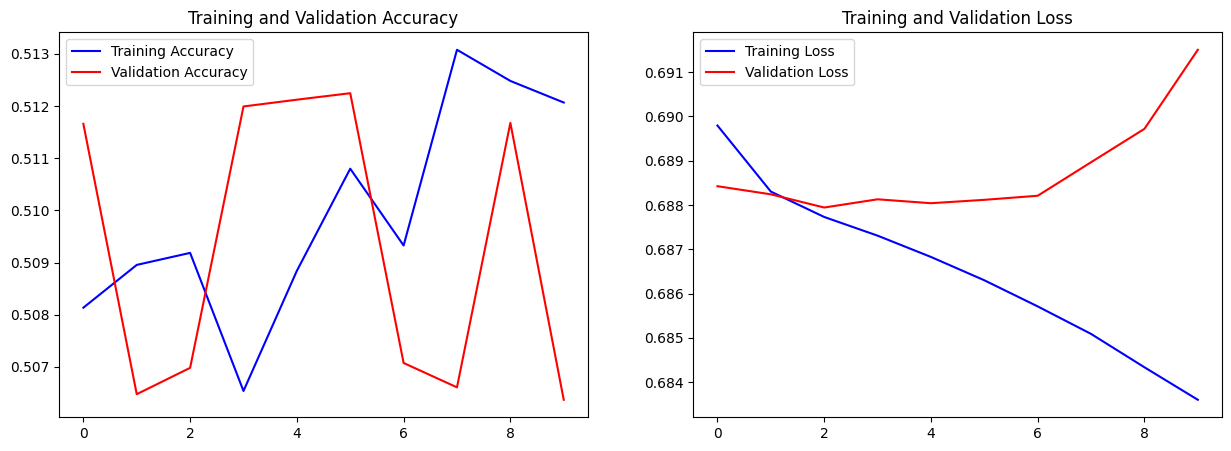

In [44]:
plot_accuracy_loss(history_glove, 'Glove Model')

In [45]:
print(f'Accuracy: {score_glove[1]}')

Accuracy: 0.5120309591293335


## Compare the accuracy of the models

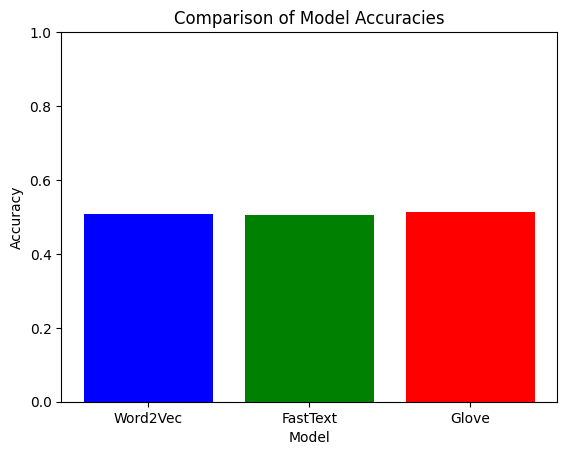

In [46]:
import matplotlib.pyplot as plt


models = ['Word2Vec', 'FastText', 'Glove']
accuracies = [score_word2vec[1], score_fasttext[1], score_glove[1]]

plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 1])  # Assuming accuracy values are between 0 and 1
plt.show()